<a href="https://colab.research.google.com/gist/Conal97/885075166472169613c39a68bed51fb9/agent-based-inhomogeneous-lattice-sezrq-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mesa
import numpy as np
import math
import random


import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [0]:
class RandomWalker(Agent):
    '''
    Class implementing random walker methods in a generalized manner.
    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.
    '''

    grid = None
    x = None
    y = None
    moore = False

    def __init__(self, pos, model, moore=False):
        '''
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.moore = moore

    def random_move(self):
        '''
        Step one cell in any allowable direction.
        '''
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)

In [0]:
class Susceptible(Agent):
  '''
  A susceptible that stays in place, and fights with zombies either getting bitten or killing the zombie.

  '''
  def __init__(self, pos, model):
      super().__init__(pos, model) 
      self.pos = pos
    

In [0]:
class Removed(Agent):
    '''
    A removed that stays in place, they are the result of a zombie being killed by a susceptible. 
    
    '''
    
    def __init__(self, pos, model):
        super().__init__(pos, model) 
        self.pos = pos
        



In [0]:
class Exposed(RandomWalker):
  '''
  An exposed that walks around, a susceptible will become exposed after being bitten by a zombie.
  If they walk into a quarantined zone they have a chance of becoming a quarantined patient that will
  then transition into a susceptible. 

  '''
  exposure_counter = None
 
  def __init__(self, pos, model, moore, exposure_counter = None):
        super().__init__(pos, model, moore = moore) 
        self.exposure_counter = random.randint(1,20)

  def step(self):
    self.random_move()
    self.exposure_counter -= 1

    # Positional stuff
    x, y = self.pos
    this_cell = self.model.grid.get_cell_list_contents([self.pos])
    exposed = [obj for obj in this_cell if isinstance(obj, Exposed)]
    Qzone = [obj for obj in this_cell if isinstance(obj, Quarantine_Zone)]

    if len (Qzone) > 0:
      # constant - probability that an exposed in a quarantine zone will become quarantined
      # choose sigma to be 0.1 - giving 10% chance that the exposed will become quarantined
      # this value is selected as we assume that it is easier to 'cure' an infected human than a full zombie
      sigma = 0.1
      if random.uniform(0.0,1.0) < sigma:
        #transition to quarantined state
        exposed_to_remove = random.choice(exposed) 
        self.model.grid._remove_agent(self.pos, exposed_to_remove)
        self.model.schedule.remove(exposed_to_remove)
        new_Qpatient = Quarantined_Patient(self.pos, self.model, self.moore)
        self.model.grid.place_agent(new_Qpatient, self.pos)
        self.model.schedule.add(new_Qpatient)

    elif len(exposed) > 0:
    # transition of exposed to zombie
      if self.exposure_counter < 0:
        exposed_to_remove = random.choice(exposed) 
        self.model.grid._remove_agent(self.pos, exposed_to_remove)
        self.model.schedule.remove(exposed_to_remove)
        # create a new zombie where the exposed agent was - maybe edit this exposed.pos and not self? 
        new_zombie = Zombie(self.pos, self.model, self.moore)
        self.model.grid.place_agent(new_zombie, self.pos)
        self.model.schedule.add(new_zombie)

In [0]:
class Quarantine_Zone(Agent):

  '''
  If an exposed or zombie walks into this zone there is a chance 
  that they will be 'cured' and transition into a quarantined state.

  '''

  def __init__(self, pos, model):

    '''
    Creates a quarantine_zone in a grid square.
    The zone is constant throughout the simulation.
    '''
    super().__init__(pos, model)
    self.pos = pos 

In [0]:
class Quarantined_Patient(RandomWalker):

  '''

  If an exposed or zombie becomes quarantined they will become
  a quarantined patient. They will remain in this state for five
  steps before become a susceptible again.

  '''

  quarantine_counter = None

  def __init__(self, pos, model, moore, quarantine_counter = None):
        super().__init__(pos, model, moore = moore) 
        self.quarantine_counter = 5

  def step(self):
    self.random_move()
    self.quarantine_counter -= 1

    # Positional stuff
    x, y = self.pos
    this_cell = self.model.grid.get_cell_list_contents([self.pos])
    quarantined = [obj for obj in this_cell if isinstance(obj, Quarantined_Patient)]

    if len(quarantined) > 0:

    # transition of quarantined to susceptible
      if self.quarantine_counter == 0:
        quarantined_to_remove = random.choice(quarantined) 
        self.model.grid._remove_agent(self.pos, quarantined_to_remove)
        self.model.schedule.remove(quarantined_to_remove)
        # create a new zombie where the exposed agent was - maybe edit this exposed.pos and not self? 
        new_susceptible = Susceptible(self.pos, self.model)
        self.model.grid.place_agent( new_susceptible,  new_susceptible.pos)
        self.model.schedule.add( new_susceptible)

        

In [0]:
class Zombie(RandomWalker):
    '''
    A zombie that walks around, and either bites or gets killed by susceptibles.
    '''

    exposure_counter = None

    def __init__(self, pos, model, moore, exposure_counter = None):
        super().__init__(pos, model,moore=moore)
        self.exposure_counter = exposure_counter
        

    def step(self):
        self.random_move()
        
        
        x, y = self.pos
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        susceptible = [obj for obj in this_cell if isinstance(obj, Susceptible)]
        zombie = [obj for obj in this_cell if isinstance(obj, Zombie)]
        Qzone = [obj for obj in this_cell if isinstance(obj, Quarantine_Zone)]
        
        if len (Qzone) > 0:
        # constant - probability that an exposed in a quarantine zone will become quarantined
        # choose zeta to be 0.05 - giving 5% chance that the exposed will become quarantined
        # this value is selected as we assume that it is difficult to 'cure' a full zombie
          zeta = 0.05
          if random.uniform(0.0,1.0) < zeta:
          #transition to quarantined state
            zombie_to_remove = random.choice(zombie) 
            self.model.grid._remove_agent(self.pos, zombie_to_remove)
            self.model.schedule.remove(zombie_to_remove)
            new_Qpatient = Quarantined_Patient(self.pos, self.model, self.moore)
            self.model.grid.place_agent(new_Qpatient, self.pos)
            self.model.schedule.add(new_Qpatient)

        
        # If there are susceptibles present, attempt to bite one
        elif len(susceptible) > 0:
          #rate constants
          beta = 0.06
          kappa = 0.018
          #rate equations to determine what happens
          k1 = beta * len(susceptible) * len(zombie)
          k2 = kappa * len(susceptible) * len(zombie)
          K = k1 + k2

          #transtition susceptible to exposed
          if random.uniform(0.0,1.0) < k1 / K:
            #randomly choose susceptible in cell and remove it
            susceptible_to_bite = random.choice(susceptible) 
            self.model.grid._remove_agent(self.pos, susceptible_to_bite)
            self.model.schedule.remove(susceptible_to_bite) 
            #place an exposed where the susceptible was
            new_exposed = Exposed(self.pos, self.model, self.moore)
            self.model.grid.place_agent(new_exposed, new_exposed.pos)
            self.model.schedule.add(new_exposed)

          #transition zombie to removed
          else:
            #randomly choose zombie in cell and remove it
            zombie_to_remove = random.choice(zombie) 
            self.model.grid._remove_agent(self.pos, zombie_to_remove)
            self.model.schedule.remove(zombie_to_remove) 
            #place a removed where the zombie was
            new_removed = Removed(self.pos, self.model)
            self.model.grid.place_agent(new_removed, new_removed.pos)
            self.model.schedule.add(new_removed)


In [0]:
from collections import defaultdict

class RandomActivationByBreed(RandomActivation):
    '''
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    Assumes that all agents have a step() method.
    '''
    agents_by_breed = defaultdict(list)

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(list)

    def add(self, agent):
        '''
        Add an Agent object to the schedule
        Args:
        agent: An Agent to be added to the schedule.
        '''

        self.agents.append(agent)
        agent_class = type(agent)
        self.agents_by_breed[agent_class].append(agent)

    def remove(self, agent):
        '''
        Remove all instances of a given agent from the schedule.
        '''

        while agent in self.agents:
            self.agents.remove(agent)

        agent_class = type(agent)
        while agent in self.agents_by_breed[agent_class]:
            self.agents_by_breed[agent_class].remove(agent)

    def step(self, by_breed=True):
        '''
        Executes the step of each agent breed, one at a time, in random order.
        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        '''
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        '''
        Shuffle order and run all agents of a given breed.
        Args:
            breed: Class object of the breed to run.
        '''
        agents = self.agents_by_breed[breed]
        random.shuffle(agents)
        for agent in agents:
            agent.step()

    def get_breed_count(self, breed_class):
        '''
        Returns the current number of agents of certain breed in the queue.
        '''
        return len(self.agents_by_breed[breed_class])

In [0]:
class ZombieApocalypse(Model):
    '''
    Zombie Apocalypse Model with zombie movement
    '''
    def __init__(self, height, width,
                 initial_susceptibles, initial_zombies,
                 initial_exposed, initial_quarantine_zone, initial_quarantine_patient,
                 initial_removed):
        '''
        Create a new zombie apocalpyse model with the given parameters.
        Args:
            initial_susceptibles: Number of susceptibles to start with
            initial_zombies: Number of zombies to start with
            initial_exposed: Number of exposed to start with 
            initial_quarantine_zone: Number of Qzones to start with
            intiial_quarantine_patient: Number of Qpatients to start with
            initial_removed: Number of removed to start with
        '''

        # Set parameters
        self.height = height
        self.width = width
        self.initial_susceptibles = initial_susceptibles
        self.initial_zombies = initial_zombies
        self.initial_exposed = initial_exposed
        self.initial_quarantine_zone = initial_quarantine_zone
        self.initial_quarantine_patient = initial_quarantine_patient
        self.initial_removed = initial_removed
       

        self.schedule = RandomActivationByBreed(self)
        self.grid = MultiGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
            {"Suseptibles": lambda m: m.schedule.get_breed_count(Susceptible),
             "Zombie": lambda m: m.schedule.get_breed_count(Zombie),
             "Exposed": lambda m: m.schedule.get_breed_count(Exposed),
             "Quarantined": lambda m: m.schedule.get_breed_count(Quarantined_Patient),
             "Removed": lambda m: m.schedule.get_breed_count(Removed)})

        # Create susceptible:
        for i in range(self.initial_susceptibles):
            x = random.randrange(self.width)
            y = random.randrange(self.height)
            susceptible = Susceptible((x, y), self)
            self.grid.place_agent(susceptible, (x, y))
            self.schedule.add(susceptible)

        # Create zombie
        for i in range(self.initial_zombies):
            x = random.randrange(self.width)
            y = random.randrange(self.height)
            exposure_counter = 3
            zombie = Zombie((x, y), self, False, exposure_counter)
            self.grid.place_agent(zombie, (x, y))
            self.schedule.add(zombie)
        
        for i in range(self.initial_quarantine_zone):
          x = random.randrange(self.width)
          y = random.randrange(self.height)
          quarantine_zone = Quarantine_Zone((x,y), self)
          self.grid.place_agent(quarantine_zone, (x,y))
          self.schedule.add(quarantine_zone)


        self.running = True

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        

In [0]:
apocalypse = ZombieApocalypse(20, 20, 199, 1, 0, 5, 0, 0)
for i in range(17000):
  apocalypse.step()

# Unfortunately some runs result in an unexpected and unexplianed dictionary error. 
# Repeatedly running the cell results in a majority of succesful runs. 
# Due to limited time this error was not investigated further.


In [0]:
results = apocalypse.datacollector.get_model_vars_dataframe()
results_array = results.to_numpy()
S = results_array[:,0]
Z = results_array[:,1]
E = results_array[:,2]
Q = results_array[:,3]
R = results_array[:,4]
time = np.linspace(0,16999,17000, endpoint=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


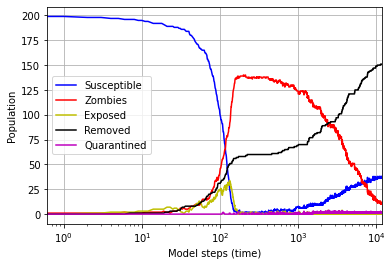

In [0]:
plt.plot(time, S, "b", label = "Susceptible")
plt.plot(time, Z, "r", label = "Zombies")
plt.plot(time, E, "y", label = "Exposed")
plt.plot(time, R, "k", label = "Removed")
plt.plot(time, Q, "m", label = "Quarantined")

plt.xlabel("Model steps (time)")
plt.xscale('log')
plt.xlim(0,12000)
plt.ylabel("Population")
plt.legend()
plt.grid()